In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from model import Autoencoder
from scipy import stats
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
train_X = pd.read_csv("data/train_X.csv")
X_test_scaled = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/y_test.csv")
val_X = pd.read_csv("data/val_X.csv")



print(train_X.shape[1])  
print(X_test_scaled.shape[1]) 

train_tensor = torch.tensor(train_X.values, dtype=torch.float32)
train_dataset = TensorDataset(train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True)
val_tensor = torch.tensor(val_X.values, dtype=torch.float32)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=1024)
print(len(train_loader.dataset)) 
print(len(val_loader.dataset))


17
17
9813926
2453482


In [9]:
model = Autoencoder(input_dim=17).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

num_epochs = 20


In [10]:
class EarlyStopping:
    def __init__(self, patience=3, delta=1e-4):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [11]:
early_stopper = EarlyStopping(patience=3)
losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    avg_train_loss = epoch_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            outputs = model(x)
            loss = criterion(outputs, x)
            val_loss += loss.item() * x.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    if early_stopper(avg_val_loss):
        print("Early stopping triggered")
        break


Epoch 1/20 | Train Loss: 0.551186 | Val Loss: 0.347774
Epoch 2/20 | Train Loss: 0.296198 | Val Loss: 0.252696
Epoch 3/20 | Train Loss: 0.236246 | Val Loss: 0.218794
Epoch 4/20 | Train Loss: 0.209858 | Val Loss: 0.204284
Epoch 5/20 | Train Loss: 0.200249 | Val Loss: 0.196882
Epoch 6/20 | Train Loss: 0.193724 | Val Loss: 0.190442
Epoch 7/20 | Train Loss: 0.187370 | Val Loss: 0.184882
Epoch 8/20 | Train Loss: 0.183522 | Val Loss: 0.182506
Epoch 9/20 | Train Loss: 0.181843 | Val Loss: 0.181237
Epoch 10/20 | Train Loss: 0.180713 | Val Loss: 0.180182
Epoch 11/20 | Train Loss: 0.179678 | Val Loss: 0.179212
Epoch 12/20 | Train Loss: 0.178874 | Val Loss: 0.178584
Epoch 13/20 | Train Loss: 0.178325 | Val Loss: 0.178073
Epoch 14/20 | Train Loss: 0.177748 | Val Loss: 0.177369
Epoch 15/20 | Train Loss: 0.176597 | Val Loss: 0.175453
Epoch 16/20 | Train Loss: 0.173099 | Val Loss: 0.170592
Epoch 17/20 | Train Loss: 0.169242 | Val Loss: 0.168442
Epoch 18/20 | Train Loss: 0.168033 | Val Loss: 0.167751
E

In [ ]:
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    reconstructions = model(X_test_tensor).cpu().numpy()

reconstruction_errors = np.mean((X_test_scaled - reconstructions) ** 2, axis=1)
X_test_scaled = np.nan_to_num(X_test_scaled)
reconstructions = np.nan_to_num(reconstructions)

reconstruction_errors = np.mean((X_test_scaled - reconstructions) ** 2, axis=1)

mean = np.mean(reconstruction_errors)
std = np.std(reconstruction_errors)
threshold = mean + 3 * std

y_pred = (reconstruction_errors > threshold).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


Threshold: 0.065214
Precision: 0.5013
Recall:    0.0162
F1 Score:  0.0314
Confusion Matrix:
[[3017465   49388]
 [3017217   49636]]


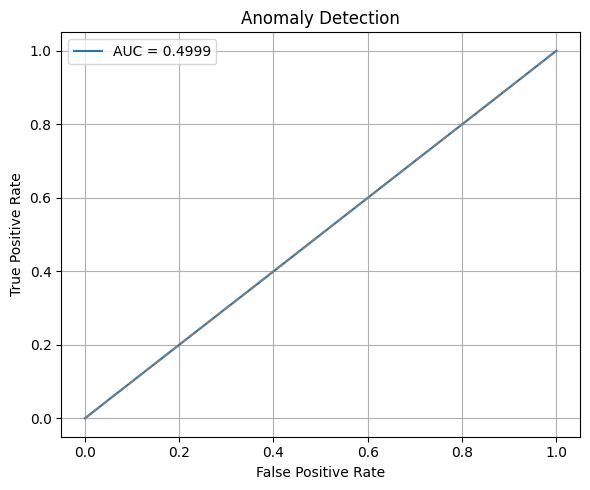

In [19]:
print(f"\nThreshold: {threshold:.6f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Anomaly Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

